In [11]:
from typing import List
import threading, logging, time
import concurrent.futures
import random
from matplotlib import pyplot as plt

Eerst moeten we een random gevulde geshuffelde list hebben.

In [2]:
def list_generator(lenList):
    """
    Vullen van lijst met meegegeven lengte.
    Waardes zitten tussen de 0 en 1000.
    """
    shuffled_list = []
    for i in range(lenList):
        n = random.randint(0,999)
        shuffled_list.append(n)
    return shuffled_list

Nu moeten we de class gaan maken waar de threads gebruik van maken om de lijst te sorteren.

In [3]:
class mergeClass(object):
    def __init__(self, unsortedList: [int], workers: int):
        """
        Set starting self values.
        """
        self.value = unsortedList
        self.dividable = workers
        self._lock = threading.Lock()
        self.workers = workers
 
    def merge(self, name, xs, status):
        """In place merge sort of array without recursive. The basic idea
        is to avoid the recursive call while using iterative solution.
        The algorithm first merge chunk of length of 2, then merge chunks
        of length 4, then 8, 16, .... , until 2^k where 2^k is large than
        the length of the array
        """
        logging.info(f"Thread %s: starting {status} ", name)
        
        unit = 1
        while unit <= len(xs):
            h = 0
            for h in range(0, len(xs), unit * 2):
                l, r = h, min(len(xs), h + 2 * unit)
                mid = h + unit
                # merge xs[h:h + 2 * unit]
                p, q = l, mid
                while p < mid and q < r:
                    # use <= for stable merge merge
                    if xs[p] <= xs[q]:
                        p += 1
                    else:
                        tmp = xs[q]
                        xs[p + 1: q + 1] = xs[p:q]
                        xs[p] = tmp
                        p, mid, q = p + 1, mid + 1, q + 1

            unit *= 2
        
        logging.info(f"Thread %s: finishing {status} ", name)
        
    def split(self):
        """
        Splits de lijst op in het aantal threads dat er gebruikt worden.
        """
        local_copy = self.value
        self.value = []
        
        while self.dividable > 0:
            indexPart = int(len(local_copy)/self.dividable)
            partOfList = local_copy[:indexPart]
            self.dividable -= 1
            local_copy = local_copy[indexPart:]
            self.value.append(partOfList)
        
    def join(self):
        """
        Plak alle uitkomsten van de threads achter elkaar en gooi dit nog 1 keer door de merge sort.
        """
        self.value = sum(self.value, [])
        self.merge('main', self.value, 'join')
        

We moeten ook een functie hebben om de tijdsduur per heel proces te berekenen.

In [4]:
def calcTime(begin, beginTime):
    """
    Setten van beginTime en endTime om zo de duur te berekenen.
    """
    if begin:
        beginTime = time.time()
        return beginTime
    else:
        endTime = time.time()
        return endTime - beginTime

Vanaf hier moet ik gaan werken met threads en deze door de vorige functies te lijden.

In [30]:
def threaded_merge_sort(amount, times, unsortedList):
    """
    Main om de threads te starten en alle threads de calculaties te laten doen.
    """
    if __name__ == "__main__":
        beginTime = calcTime(True, 0)

        currentList = mergeClass(unsortedList, amount)
        logging.info(f"Updating. Amount of cores: {amount}.")

        with concurrent.futures.ThreadPoolExecutor(max_workers=amount) as executor:
            currentList.split()
            for index in range(amount):
                executor.submit(currentList.merge, index, currentList.value[index], 'update')

        endTime = calcTime(False, beginTime)

        currentList.join()

        logging.info(f"Updating. Time in seconds: {endDTime}\n")
        times.append(endTime)
        return times

Om alle voorgaande resultaten te laten zien gebruik ik plt voor iedere size list met het aantal threads dat er gebruikt worden.

In [64]:
def plt_runtime(amountWorkers, times, len_list, amount_len_lists):
    """
    Plot the different tested scenario's.
    """
    fig = plt.figure(figsize=(12, 8))
    
    plt.title(f"runtime with {len_list} values") 
    plt.xlabel("Amount of threads")
    plt.ylabel("Time (s)")
    
    for index in range(len(times)):
        plt.plot(amountWorkers, times[index], label=f"{amount_len_lists[index]} values")
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

Om te kijken wanneer meerdere threads efficient zijn moet ik ook verschillende lengtes van lijsten testen.

In [67]:
def diff_len_lists():
    """
    Loop door het hele proces heen en doe dit met verschillende lengte van lists.
    """
    amountWorkers = [1, 2, 4, 8]
    amount_len_lists = [100, 1000, 5000, 10000]
    times = []

    for lengths in amount_len_lists:
        local_times = []
        len_random_list = lengths
        unsortedList = list_generator(len_random_list)

        for amount in amountWorkers:
            local_times = threaded_merge_sort(amount, local_times, unsortedList)
        times.append(local_times)

    plt_runtime(amountWorkers, times, len_random_list, amount_len_lists)

Aanroepen van het hele proces

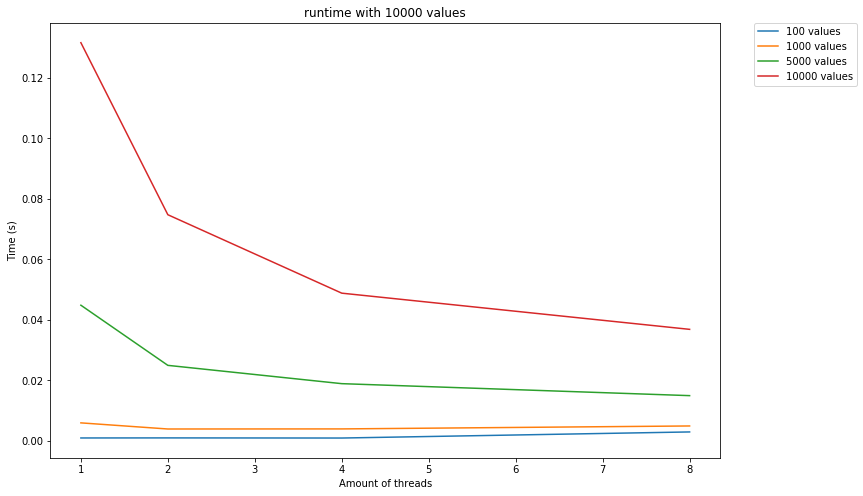

In [69]:
diff_len_lists()

# Ontwerpen

#### Comunicatie overhead 1 thread
Bij het ontwerp hier onder heb je 2 communication overhead.\
1 bij het splitten en 1 bij het mergen wat samen 2 maakt.

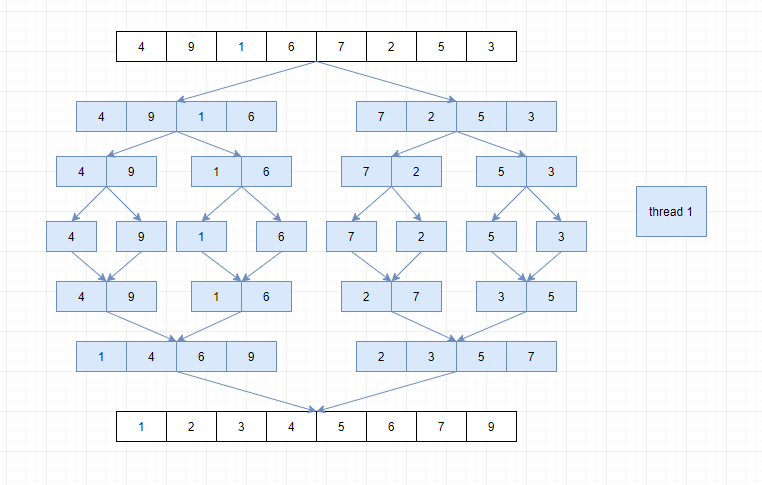

#### Comunicatie overhead 2 threads
Bij het ontwerp hier onder heb je 4 communication overhead.\
2 bij het splitten en 2 bij het mergen wat samen 4 maakt.

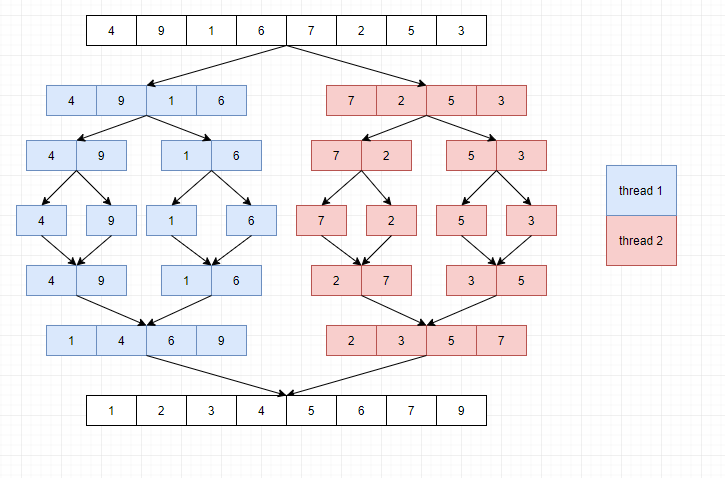

#### Comunicatie overhead 4 threads
Bij het ontwerp hier onder heb je 8 communication overhead.\
4 bij het splitten en 4 bij het mergen wat samen 8 maakt.

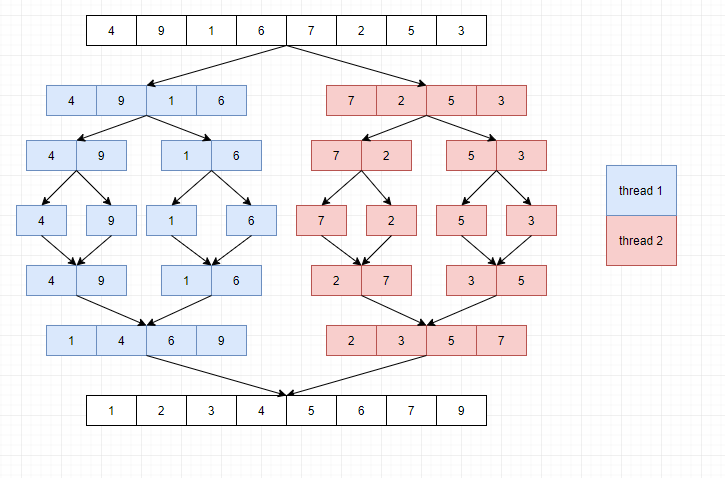

#### Comunicatie overhead
Bij het ontwerp hier onder heb je 16 communication overhead.\
8 bij het splitten en 8 bij het mergen wat samen 16 maakt.

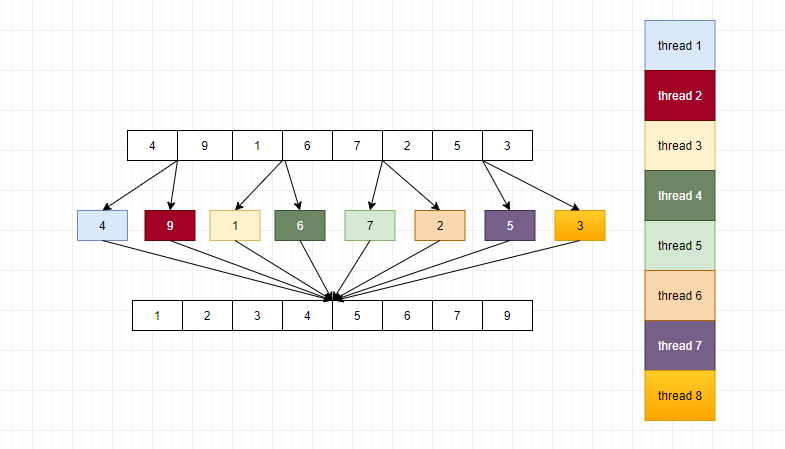

## Conclusie
Bij een lijst van 100 values is 1 thread sneller dan 8 threads. Dit komt doordat het verdelen over de 8 threads en weer joinen langer duurt dan dat het oplevert om het werk te verdelen.\
Bij een list met duizend values zie je dat de vrijwel overal gelijk is. Dit is het omkeer punt vanaf waar 8 threads efficienter gaat worden om te gebruiken dan 1 thread.\
Bij de 10 duizend threads kun je dan echt goed zien dat het sneller is om 8 threads te gebruiken bij een lange lijst om te sorteren. Hier duurt het niet langer om alles over de 8 threads te verdelen en later weer te joinen dan dat het je tijd oplevert door 8 threads tegelijkertijd te runnen.

## Global Interpreter lock
De Global interpreter lock zorgt er voor dat je computer maar 1 thread tergelijkertijd code laat executen.\
Hierdoor kunnen threads niet tegelijkertijd lopen en zal het ook niet sneller kunnen zijn om meerdere threads het werk te laten doen. Dit omdat ze alles na elkaar moeten doen waardoor er geen tijd gewonnen word.

## Bronnen:
basis threads: https://canvas.hu.nl/courses/20310/assignments/126249?module_item_id=497156 \
basis merge sort: https://canvas.hu.nl/courses/20310/assignments/126241